In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Input, Lambda, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

In [2]:
import torch
import torch.nn as nn

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"divyanshijoshi","key":"4cf4ad7341cdc5b961f91df3dd74a735"}'}

In [4]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [5]:
!kaggle datasets download -d shadmanrohan/collisionavoidancechallenge

Dataset URL: https://www.kaggle.com/datasets/shadmanrohan/collisionavoidancechallenge
License(s): unknown
 91% 97.0M/107M [00:00<00:00, 120MB/s]
100% 107M/107M [00:00<00:00, 123MB/s] 


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('collisionavoidancechallenge.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
train_data= pd.read_csv('/content/train_data.csv')
test_data= pd.read_csv('/content/test_data.csv')

In [8]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.5 MB/s eta 0:00:00


In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import missingno

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, fbeta_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from category_encoders import BinaryEncoder

from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam

In [13]:
df = pd.read_csv("train_data.csv")
timestep = 17 #from 1 to 23 (17 with the current NaN strategy)
threshold_for_classification = -8
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
fill_X = -0.01
seed = 11

#RNN hiperparameter
epochs = 75
batch = 64
val_split = 0.25
test_split = 0.25
lr = 0.0001
adam = optimizers.Nadam() #(lr)
class_weight = {True:  5.,
                False: 1.}
verbose = 1

In [14]:
#Dropping first the empty column and then rows with NaNs
df = df.drop("c_rcs_estimate", axis=1)
df = df.dropna(how='any')

#Filtering events with len=1 or min_tca > 2 or max_tca < 2
def conditions(event):
    x = event["time_to_tca"].values
    return ((x.min()<2.0) & (x.max()>2.0) & (x.shape[0]>1))
df = df.groupby('event_id').filter(conditions)

#OHE for c_object_type (5 categories) -> 5 new features
df["mission_id"] = df["mission_id"].astype('category')
df["c_object_type"] = df["c_object_type"].astype('category')
df = pd.get_dummies(df)

#Getting y as 1D-array
y = df.groupby(["event_id"])["risk"].apply(lambda x: x.iloc[-1]).values.reshape(-1, 1)

#Scaling y
_ = y_scaler.fit(df["risk"].values.reshape(-1, 1)) #using the whole risk feature to scale the target 'y'
y = y_scaler.transform(y)

#Getting X as df (dropping rows with tca < 2)
df = df.loc[df["time_to_tca"]>2]

#Adding feature 'event_length' for counting how many instances each event has
df["event_length"] = df.groupby('event_id')['event_id'].transform('count')

#Scaling X
df = pd.DataFrame(X_scaler.fit_transform(df), columns=df.columns)

#Transforming X into a 3D-array
events = df["event_id"].nunique() #rows
features = len(df.columns) #columns

X = np.zeros((events,timestep,features))
X.fill(fill_X)

i = 0
def df_to_3darray(event):
    global X, i
    #Transforming an event to time series (1,timesteps, columns)
    row = event.values.reshape(1,event.shape[0],event.shape[1])
    #Condition is needed to slice arrays correctly
    #Condition -> is timestep greater than the event's time series length?
    if(timestep>=row.shape[1]):
        X[i:i+1,-row.shape[1]:,:] = row
    else:
        X[i:i+1,:,:] = row[:,-timestep:,:]
    #index to iterate over X array
    i = i + 1
    #dataframe remains intact, while X array has been filled.
    return event

df.groupby("event_id").apply(df_to_3darray)

#Dropping event_id to remove noise
X = X[:,:,1:]

#TODO: Padding with specific values column-wise instead of zeros.
#TODO: Separating time dependent and independent feature in 2 X arrays

print(X.shape, y.shape)

<ipython-input-14-3475b681b884>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["event_length"] = df.groupby('event_id')['event_id'].transform('count')


(7311, 17, 124) (7311, 1)


In [15]:
#computing scaled threshold
th = np.array([threshold_for_classification]).reshape(-1,1)
th = y_scaler.transform(th)
threshold_scaled = th[0,0]

#Splitting arrays
y_boolean = (y > threshold_scaled).reshape(-1,1)
X_train, X_test, y_train_numeric, y_test_numeric = train_test_split(X, y,
                                                    stratify=y_boolean,
                                                    shuffle=True,
                                                    random_state=seed,
                                                    test_size = test_split
                                                  )

y_train_boolean = (y_train_numeric > threshold_scaled).reshape(-1,1)
X_train, X_val, y_train_numeric, y_val_numeric = train_test_split(X_train, y_train_numeric,
                                                    stratify=y_train_boolean,
                                                    shuffle=True,
                                                    random_state=seed,
                                                    test_size = val_split
                                                  )
#transforming it into a classification task -> y_train, y_test boolean
y_train = (y_train_numeric > threshold_scaled).reshape(-1,1)
y_val = (y_val_numeric > threshold_scaled).reshape(-1,1)
y_test = (y_test_numeric > threshold_scaled).reshape(-1,1)

#Percentage of high risks in train
print("TRAIN {:0.1f}, {:0.1f}, {:0.3f}".format(np.sum(y_train), y_train.shape[0], np.sum(y_train)/y_train.shape[0]))
#Percentage of high risks in val
print("VAL   {:0.1f}, {:0.1f}, {:0.3f}".format(np.sum(y_val), y_val.shape[0], np.sum(y_val)/y_val.shape[0]))
#Percentage of high risks in test
print("TEST  {:0.1f}, {:0.1f}, {:0.3f}".format(np.sum(y_test), y_test.shape[0], np.sum(y_test)/y_test.shape[0]))

TRAIN 199.0, 4112.0, 0.048
VAL   66.0, 1371.0, 0.048
TEST  88.0, 1828.0, 0.048


In [16]:
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

In [17]:
from tensorflow.keras.regularizers import L1L2
# Model activation selu
input_tensor = Input(batch_shape=(batch, timestep, X_train.shape[2]))
rnn_1 = LSTM(32, stateful=False, dropout=0.15, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=L1L2(l1=0.0, l2=0.01))(input_tensor)
batch_1 = BatchNormalization()(rnn_1)
rnn_2 = LSTM(16, stateful=False, dropout=0.15, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=L1L2(l1=0.0, l2=0.01))(batch_1)
batch_2 = BatchNormalization()(rnn_2)
rnn_3 = LSTM(8, stateful=False, dropout=0.15, recurrent_dropout=0.3, return_sequences=False, kernel_regularizer=L1L2(l1=0.0, l2=0.01))(batch_2)
batch_3 = BatchNormalization()(rnn_3)
output_tensor = Dense(units = 1, activation='sigmoid')(batch_3)

model = Model(inputs=input_tensor,
              outputs= output_tensor)

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(64, 17, 124)]           0         
                                                                 
 lstm (LSTM)                 (64, 17, 32)              20096     
                                                                 
 batch_normalization (Batch  (64, 17, 32)              128       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (64, 17, 16)              3136      
                                                                 
 batch_normalization_1 (Bat  (64, 17, 16)              64        
 chNormalization)                                                
                                                                 
 lstm_2 (LSTM)               (64, 8)                   800   

In [18]:
model_history = model.fit(X_train, y_train,
                          epochs=60,
                          batch_size=batch,
                          #shuffle=True, #OJO
                          validation_data=(X_val, y_val),
                          verbose=verbose,
                          class_weight=class_weight
                         ).history

Epoch 1/60
65/65 [==============================] - 31s 215ms/step - loss: 2.3025 - accuracy: 0.5598 - val_loss: 1.7378 - val_accuracy: 0.9380
Epoch 2/60
65/65 [==============================] - 13s 203ms/step - loss: 1.6085 - accuracy: 0.6904 - val_loss: 1.2108 - val_accuracy: 0.9519
Epoch 3/60
65/65 [==============================] - 14s 209ms/step - loss: 1.2366 - accuracy: 0.7721 - val_loss: 0.9297 - val_accuracy: 0.9519
Epoch 4/60
65/65 [==============================] - 12s 189ms/step - loss: 1.0154 - accuracy: 0.8278 - val_loss: 0.7322 - val_accuracy: 0.9519
Epoch 5/60
65/65 [==============================] - 12s 175ms/step - loss: 0.8578 - accuracy: 0.8594 - val_loss: 0.5941 - val_accuracy: 0.9504
Epoch 6/60
65/65 [==============================] - 15s 225ms/step - loss: 0.7536 - accuracy: 0.8891 - val_loss: 0.5452 - val_accuracy: 0.9468
Epoch 7/60
65/65 [==============================] - 13s 204ms/step - loss: 0.6777 - accuracy: 0.8796 - val_loss: 0.4270 - val_accuracy: 0.9497

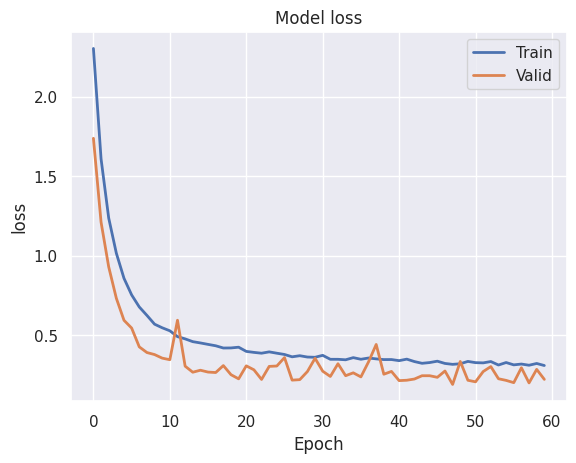

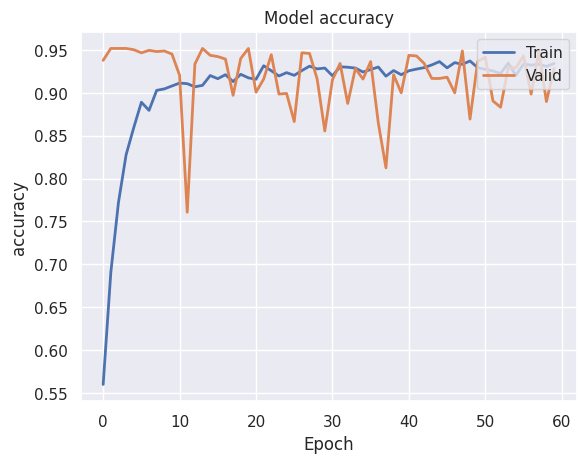

In [19]:
sns.set()

for graph in ['loss', 'accuracy']:

    plt.plot(model_history[graph], linewidth=2, label='Train')
    plt.plot(model_history['val_'+graph], linewidth=2, label='Valid')

    plt.legend(loc='upper right')
    plt.title('Model '+graph)
    plt.ylabel(graph)
    plt.xlabel('Epoch')

    plt.show()

In [20]:
print("Training accuracy:", model_history['accuracy'][-1] * 100, '%')
print("Validation accuracy:", model_history['val_accuracy'][-1] * 100, '%')


Training accuracy: 93.43385100364685 %
Validation accuracy: 92.85193085670471 %


In [24]:
!pip install scikit-learn
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error, fbeta_score

29/29 [==============================] - 2s 66ms/step


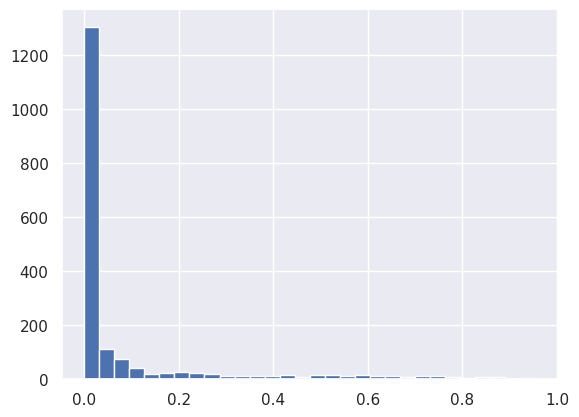

LSTM model: 4.921, 1.001, 0.203


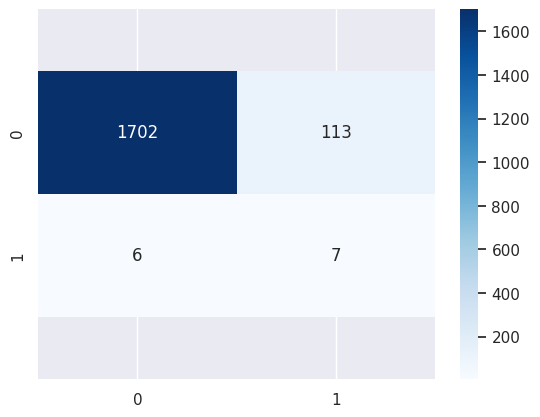

Constant prediction: 9.958, 0.344, 0.035


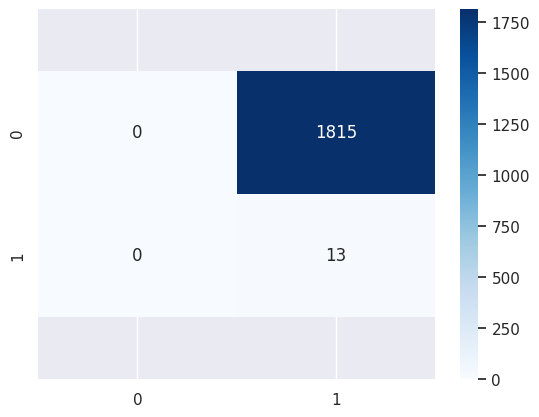

Predicting last value: 1.223, 0.527, 0.431


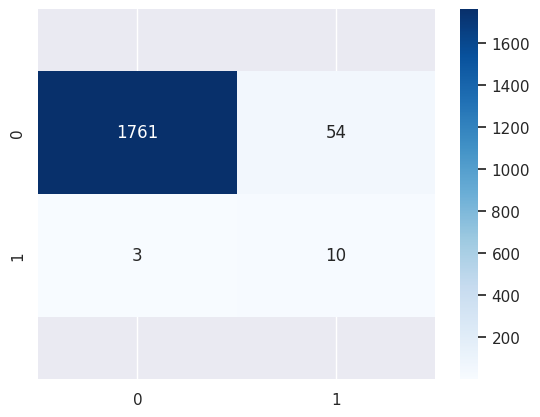

In [26]:
#Model Evaluation
high_risk_real_value = -5.0
low_risk_real_value  = -6.0001
classification_threshold = 0.51

def evaluate(name, y_pred):

    #rescaling data
    y_test_scaled = y_scaler.inverse_transform(y_test_numeric)

    #getting numeric predictions from boolean predictions
    y_pred_numeric = np.zeros((y_pred.shape[0],y_pred.shape[1]))
    y_pred_numeric[y_pred==True] = high_risk_real_value
    y_pred_numeric[y_pred==False] = low_risk_real_value

    #getting predictions greater than -6.0 in real data (y_test_scaled)
    y_pred_mse = y_pred_numeric[np.where(y_test_scaled >= -6.0)]
    y_test_mse = y_test_scaled[np.where(y_test_scaled >= -6.0)]

    mse = mean_squared_error(y_test_mse, y_pred_mse)

    y_real_bool = (y_test_scaled >= -6.0).reshape(-1,1)

    f_beta = fbeta_score(y_real_bool, y_pred, beta = 2)
    score = mse / f_beta
    print(name, "{:0.3f}, {:0.3f}, {:0.3f}".format(score, mse, f_beta))

    hm = sns.heatmap(confusion_matrix(y_real_bool, y_pred), annot=True, cmap="Blues", fmt='d')# font size
    bottom, top = hm.get_ylim()
    hm.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

#Predicting with model
y_model = model.predict(X_test, batch_size=batch)
plt.hist(y_model, bins=30)
plt.show()
y_model = (y_model > classification_threshold).reshape(-1,1)
evaluate("LSTM model:", y_model)

#Predicting -5 always
y_constant = np.ones((y_test.shape[0],y_test.shape[1]), dtype=bool)
evaluate("Constant prediction:", y_constant)

#Predicting last value
y_last = X_test[:,-1,1]
tmp = np.array([-6]).reshape(-1,1)
tmp = y_scaler.transform(tmp)
tmp = tmp[0,0]
y_last = (y_last > tmp).reshape(-1,1)
evaluate("Predicting last value:", y_last)


Predicting last value: 23.351, 10.065, 0.431


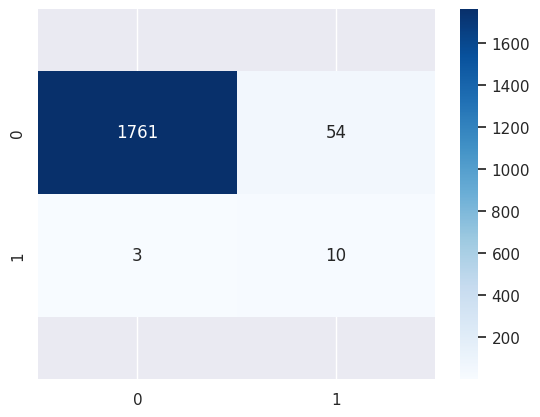

In [29]:
#Predicting last value
def recurrent_evaluate(name, y_pred):

    #Scaling both real predicted
    y_pred_scaled = y_scaler.inverse_transform(y_pred)
    y_real_scaled = y_scaler.inverse_transform(y_test_numeric)

    #boolean data
    y_pred_bool = (y_pred_scaled >= -6.0).reshape(-1,1)
    y_real_bool = (y_real_scaled >= -6.0).reshape(-1,1)
    f_beta = fbeta_score(y_real_bool, y_pred_bool, beta = 2)

    #getting predictions greater than -6.0 in real data (y_real_scaled)
    y_pred_mse = y_pred_scaled[np.where(y_real_scaled >= -6.0)]
    y_real_mse = y_real_scaled[np.where(y_real_scaled >= -6.0)]
    mse = mean_squared_error(y_real_mse, y_pred_mse)

    #F-beta score
    score = mse / f_beta
    print(name, "{:0.3f}, {:0.3f}, {:0.3f}".format(score, mse, f_beta))

    #Confusion matrix
    hm = sns.heatmap(confusion_matrix(y_real_bool, y_pred_bool), annot=True, cmap="Blues", fmt='d')# font size
    bottom, top = hm.get_ylim()
    hm.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()


y_last = X_test[:,-1,1].reshape(-1,1)
y_bool_2 = recurrent_evaluate("Predicting last value:", y_last)